In [ ]:
import numpy as np
from citeline.database.milvusdb import MilvusDB
import matplotlib.pyplot as plt

db = MilvusDB()
print(db)

In [2]:
db.list_collections()

Collections:
 - astrobert_chunks: 460801 entities
 - astrobert_contributions: 89860 entities
 - bge_chunks: 460801 entities
 - bge_contributions: 89860 entities
 - nasa_chunks: 460801 entities
 - nasa_contributions: 89860 entities
 - qwen06_chunks: 460801 entities
 - qwen06_contributions: 89860 entities
 - qwen06_findings_v2: 4342 entities
 - qwen8b_contributions: 89860 entities
 - specter_chunks: 460801 entities
 - specter_contributions: 89860 entities


In [98]:
vectors = db.get_all_vectors("qwen06_chunks")
chunk_vectors = np.array(vectors)
del vectors

chunk_vectors.shape

Retrieving all vectors from collection 'qwen06_chunks' with 460801 entities...


Retrieving vectors: 100%|██████████| 460801/460801 [00:45<00:00, 10118.46it/s]


Retrieved 460801 vectors from collection 'qwen06_chunks'


(460801, 1024)

In [99]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None) # for all components
pca.fit(chunk_vectors)


PCA()

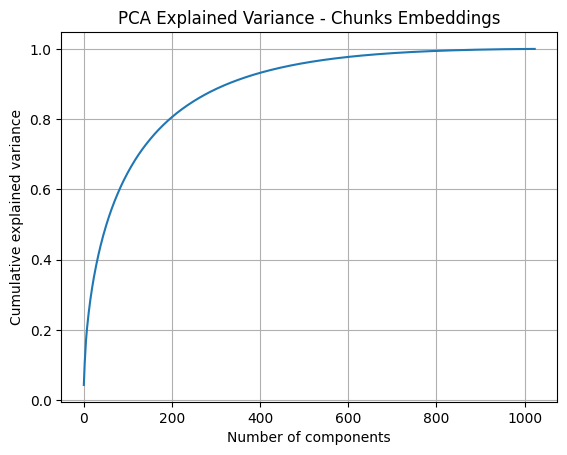

In [100]:
# Proportion of variance explained by each component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Explained Variance - Chunks Embeddings')
plt.grid()
plt.savefig('../plots/chunk_embeddings_pca_explained_variance.png', dpi=300)
plt.show()

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
chunks_tsne = tsne.fit_transform(chunk_vectors)

/Users/benjaminbasseri/miniforge3/envs/citeline/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


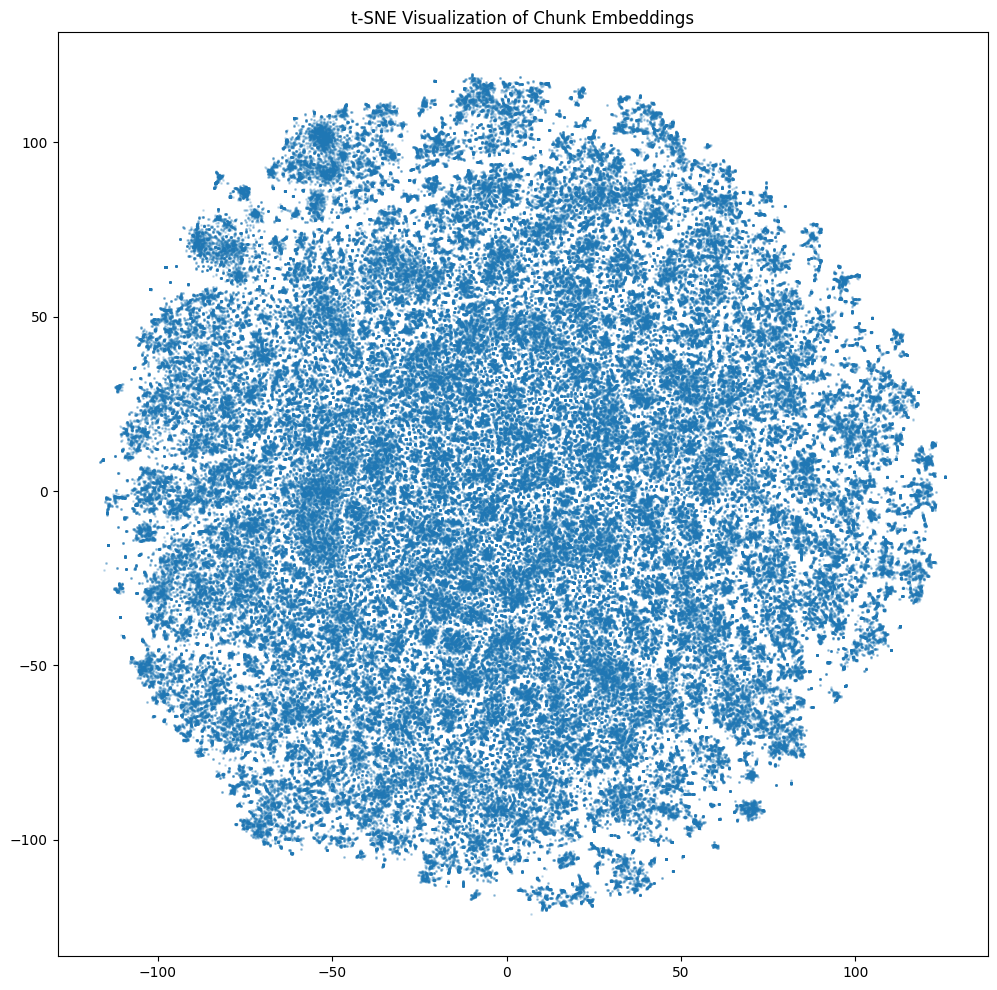

In [27]:
plt.figure(figsize=(12, 12))
plt.scatter(chunks_tsne[:, 0], chunks_tsne[:, 1], s=1, alpha=0.2)
plt.title('t-SNE Visualization of Chunk Embeddings')
plt.savefig('../plots/chunk_embeddings_tsne.png', dpi=300)
plt.show()

In [20]:
# Repeat for contributions

vectors = db.get_all_vectors("qwen06_contributions")
contribution_vectors = np.array(vectors)
del vectors

Retrieving all vectors from collection 'qwen06_contributions' with 89860 entities...


Retrieving vectors: 100%|██████████| 89860/89860 [00:05<00:00, 16913.86it/s]


Retrieved 89860 vectors from collection 'qwen06_contributions'


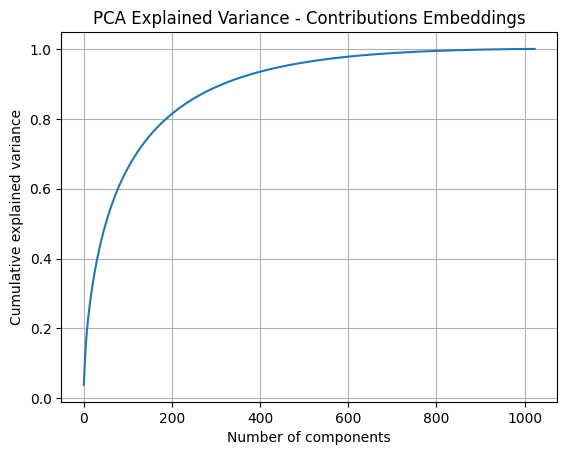

In [21]:
pca = PCA(n_components=None) # for all components
pca.fit(contribution_vectors)


# Proportion of variance explained by each component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Explained Variance - Contributions Embeddings")
plt.grid()
plt.savefig("../plots/contribution_embeddings_pca_explained_variance.png", dpi=300)
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 89860 samples in 0.018s...
[t-SNE] Computed neighbors for 89860 samples in 39.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 89860
[t-SNE] Computed conditional probabilities for sample 2000 / 89860
[t-SNE] Computed conditional probabilities for sample 3000 / 89860
[t-SNE] Computed conditional probabilities for sample 4000 / 89860
[t-SNE] Computed conditional probabilities for sample 5000 / 89860
[t-SNE] Computed conditional probabilities for sample 6000 / 89860
[t-SNE] Computed conditional probabilities for sample 7000 / 89860
[t-SNE] Computed conditional probabilities for sample 8000 / 89860
[t-SNE] Computed conditional probabilities for sample 9000 / 89860
[t-SNE] Computed conditional probabilities for sample 10000 / 89860
[t-SNE] Computed conditional probabilities for sample 11000 / 89860
[t-SNE] Computed conditional probabilities for sample 12000 / 89860
[t-SNE] Computed conditional probabilities for sa

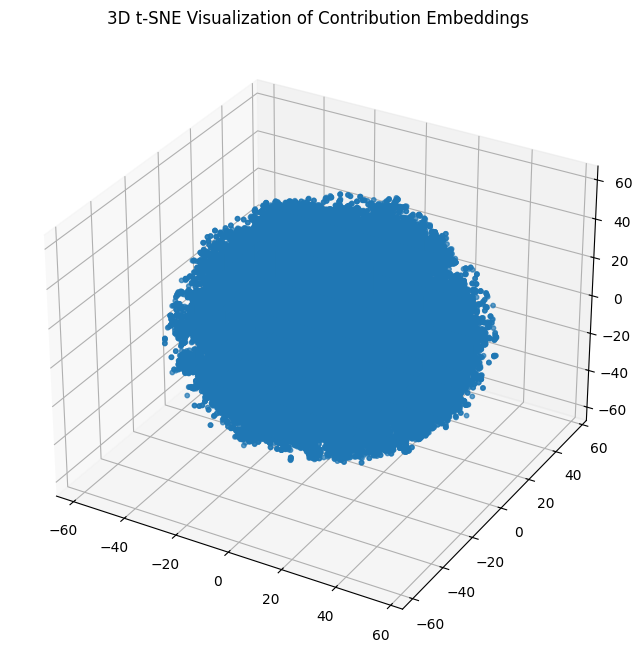

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


tsne = TSNE(n_components=3, perplexity=30, random_state=42, max_iter=1000, verbose=1)
X_embedded = tsne.fit_transform(contribution_vectors)


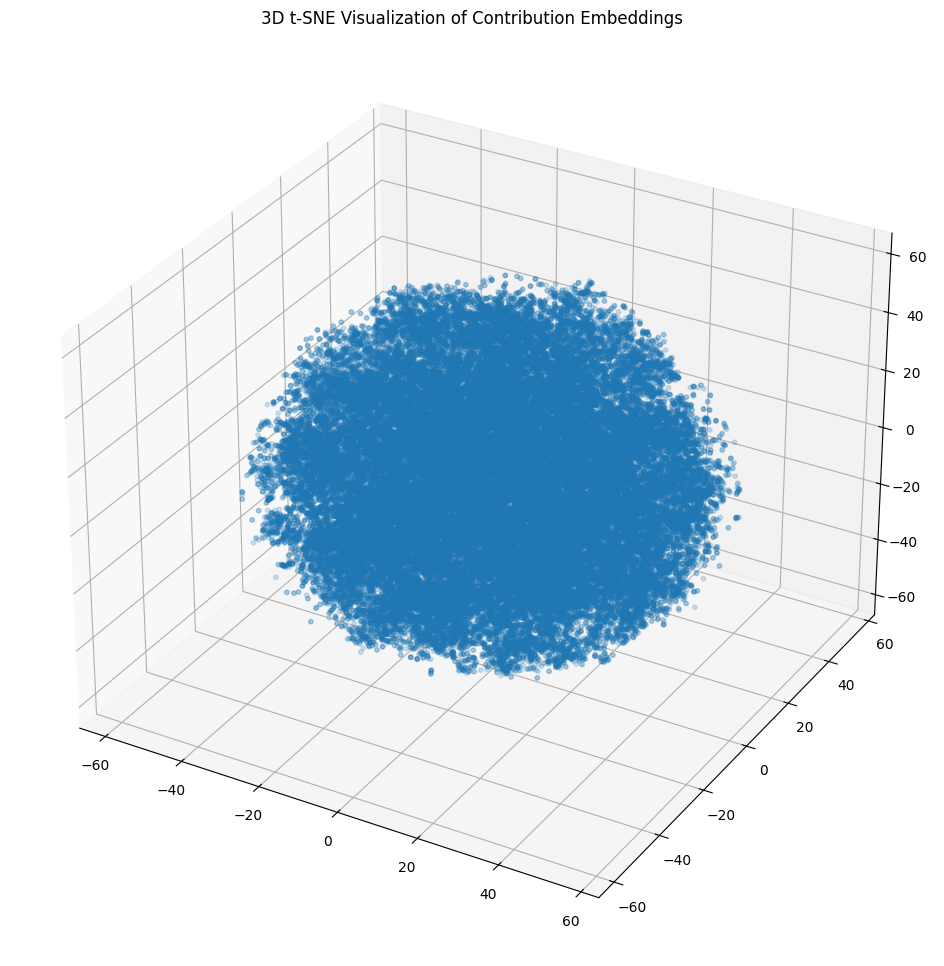

In [30]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], s=10, alpha=0.2)
ax.set_title("3D t-SNE Visualization of Contribution Embeddings")
plt.show()

## Sample Out of Domain Text

While there do not appear to be clusters within the research dataset, they are all natural science papers. To see if a general purpose embedder is discriminating between these papers well, let's add out of domain text embeddings to the dataset and revisualize using t-SNE. 



In [ ]:
from nltk.corpus import brown
from semantic_text_splitter import TextSplitter
from mosestokenizer import MosesDetokenizer
import numpy as np # for random sampling
from citeline.embedders import Embedder
from tqdm import tqdm

detok = MosesDetokenizer("en")
embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True) 

In [79]:
# Prepare array to hold 5000 embeddings (Using Qwen 3 0.6B)
num_embeddings = 5000
paras_per_file = 10 # There are 500 files in the Brown corpus
dim = 1024 
brown_embeddings = np.zeros((num_embeddings, dim), dtype=np.float32)


for i, fileid in tqdm(enumerate(brown.fileids()), total=len(brown.fileids())):
    # Get the paragraphs from this file and sample 10 random ones
    paras = brown.paras(fileids=fileid)

    # if there are less paragraphs in the file than we want, allow replacement
    replace = len(paras) < paras_per_file 
    indices = np.random.choice(len(paras), size=paras_per_file, replace=replace)

    # Detokenize the sampled paragraphs & embed
    paras_sampled = []
    for idx in indices:
        para_tokens = paras[idx]
        natural_para = detok([" ".join(sent) for sent in para_tokens])
        paras_sampled.append(natural_para)

    embeddings = embedder(paras_sampled)
    brown_embeddings[i*paras_per_file:(i+1)*paras_per_file, :] = embeddings

print(brown_embeddings.shape)  # (5000, 1024)

100%|██████████| 500/500 [09:34<00:00,  1.15s/it]

(5000, 1024)


In [80]:
# Sample the domain embeddings
sample_indices = np.random.choice(len(chunk_vectors), size=num_embeddings, replace=False)
chunk_vectors_sampled = chunk_vectors[sample_indices]

# Combine the embeddings
all_embeddings = np.vstack([chunk_vectors_sampled, brown_embeddings])
all_embeddings.shape  # (2*num_embeddings, 1024)

(10000, 1024)

In [81]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, verbose=1)
all_embeddings_fit = tsne.fit_transform(all_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 0.658s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.269850
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.760849
[t-SNE] KL divergence after 1000 iterations: 2.449253


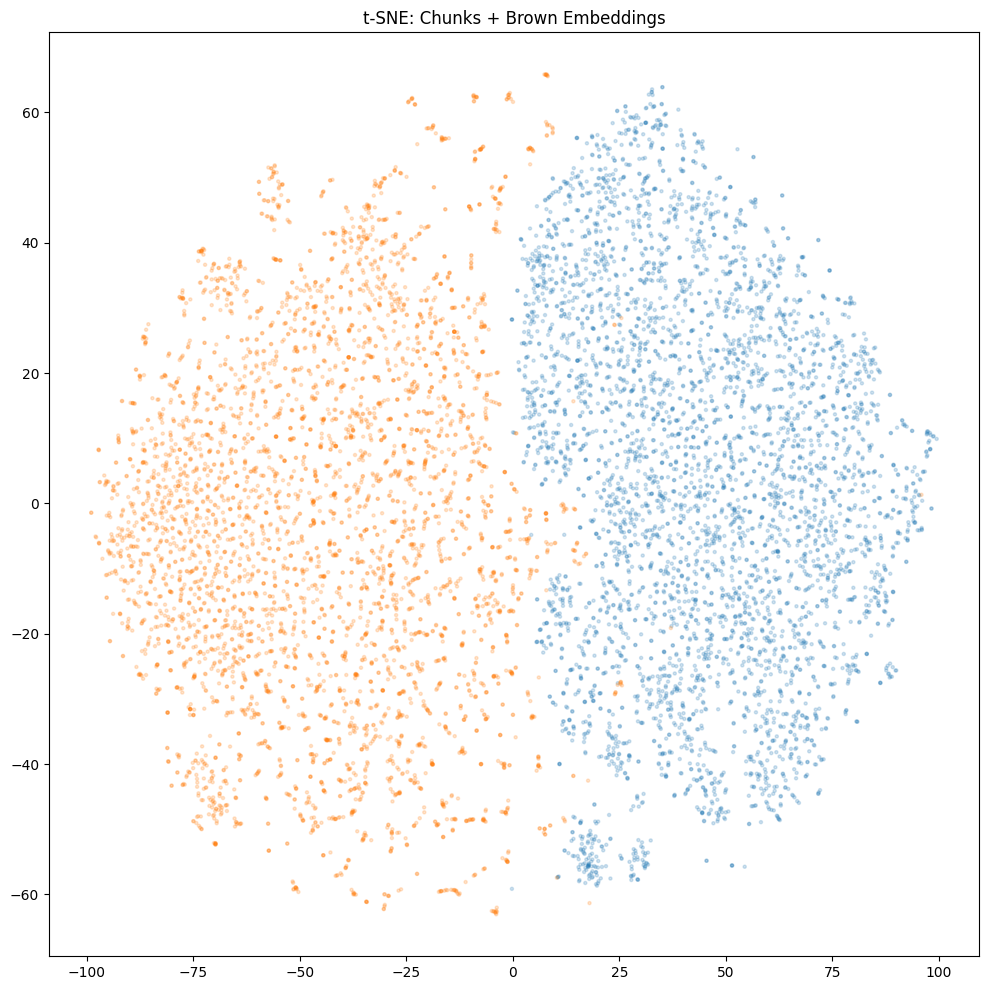

In [83]:
plt.figure(figsize=(12, 12))
colors = np.array(['tab:blue'] * num_embeddings + ['tab:orange'] * num_embeddings)
plt.scatter(all_embeddings_fit[:, 0], all_embeddings_fit[:, 1], s=5, alpha=0.2, c=colors)
plt.title("t-SNE: Chunks + Brown Embeddings")
plt.savefig("../plots/chunk_embeddings_tsne.png", dpi=300)
plt.show()

In [84]:
all_embeddings_3d = TSNE(n_components=3, random_state=42, perplexity=30, max_iter=1000, verbose=1).fit_transform(all_embeddings)
all_embeddings_3d.shape  # (10000, 3)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 0.596s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.269850
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.917160
[t-SNE] KL divergence after 1000 iterations: 2.238537


(10000, 3)

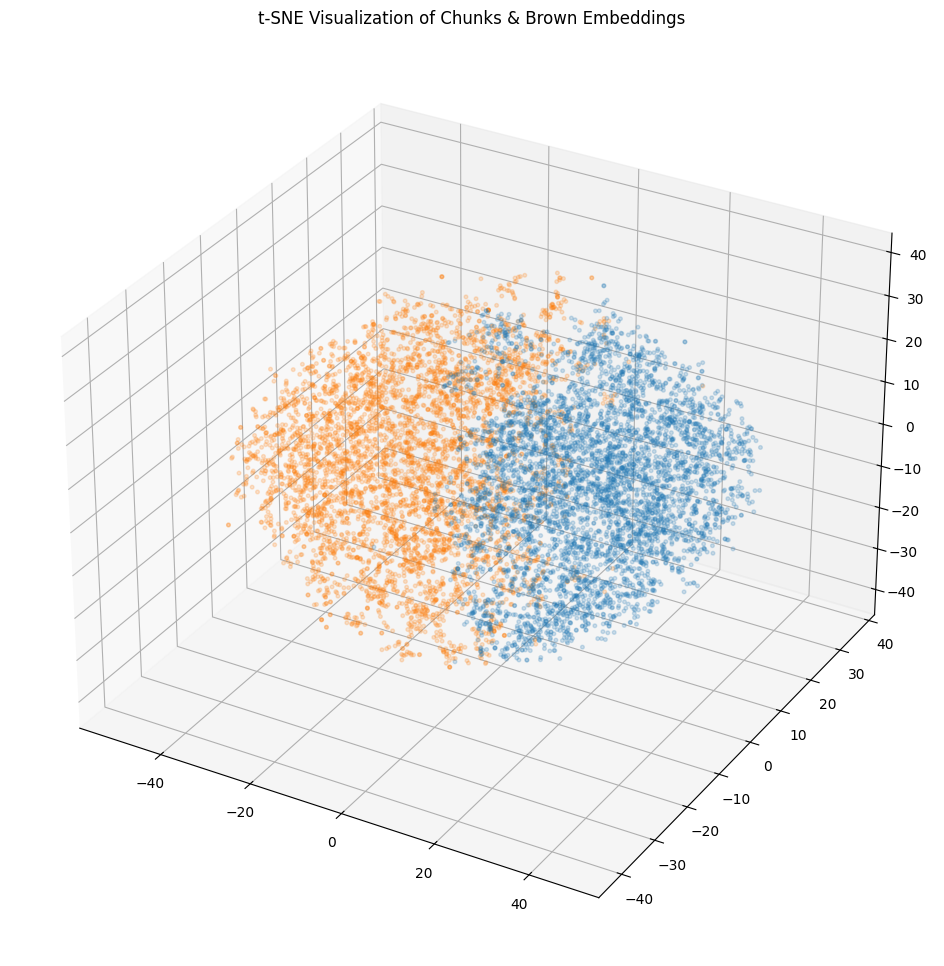

In [86]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(all_embeddings_3d[:, 0], all_embeddings_3d[:, 1], all_embeddings_3d[:, 2], s=7, alpha=0.2, c=colors)
ax.set_title("t-SNE Visualization of Chunks & Brown Embeddings")
plt.show()

In [87]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [88]:
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings)
all_embeddings_pca.shape  # (10000, 2)

(10000, 2)

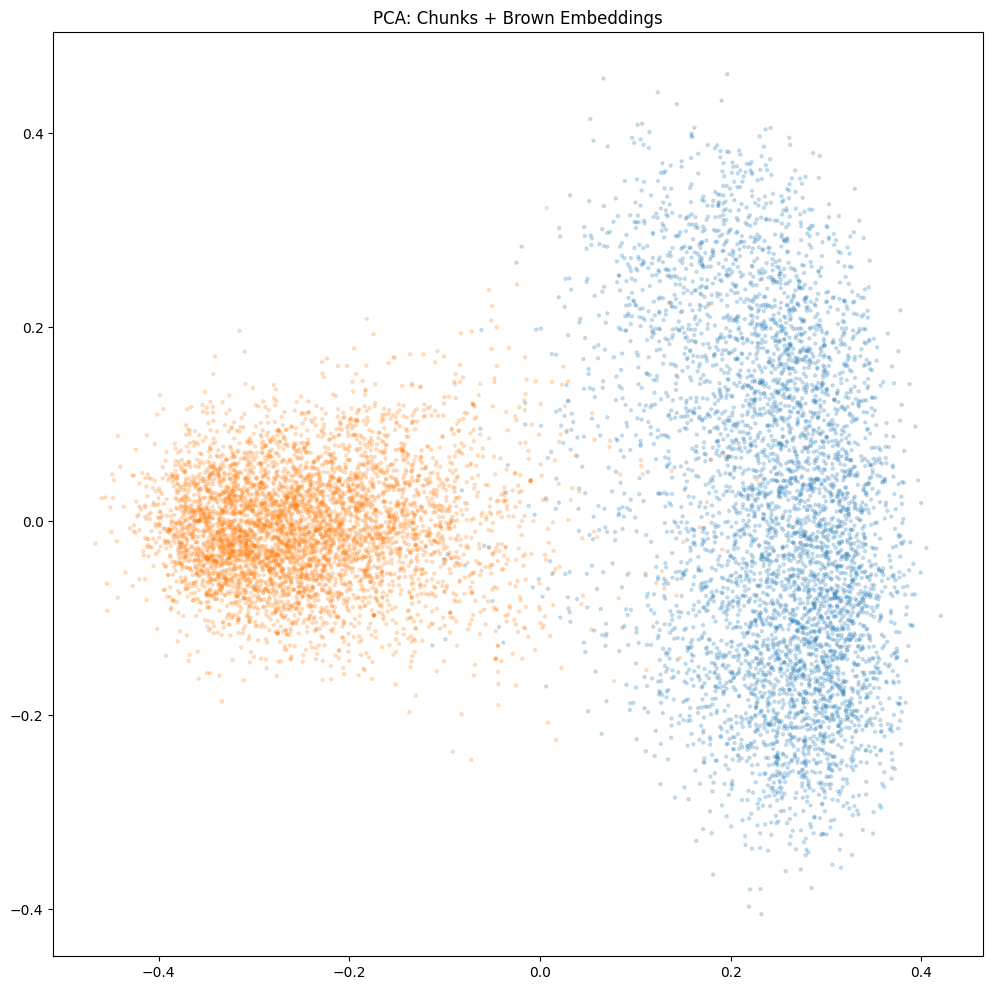

In [89]:
plt.figure(figsize=(12, 12))
colors = np.array(['tab:blue'] * num_embeddings + ['tab:orange'] * num_embeddings)
plt.scatter(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1], s=5, alpha=0.2, c=colors)
plt.title("PCA: Chunks + Brown Embeddings")
plt.savefig("../plots/chunk_embeddings_tsne.png", dpi=300)
plt.show()

In [90]:
pca = PCA(n_components=3) # for all components
all_embeddings_pca = pca.fit_transform(all_embeddings)
all_embeddings_pca.shape  # (10000, 3)

(10000, 3)

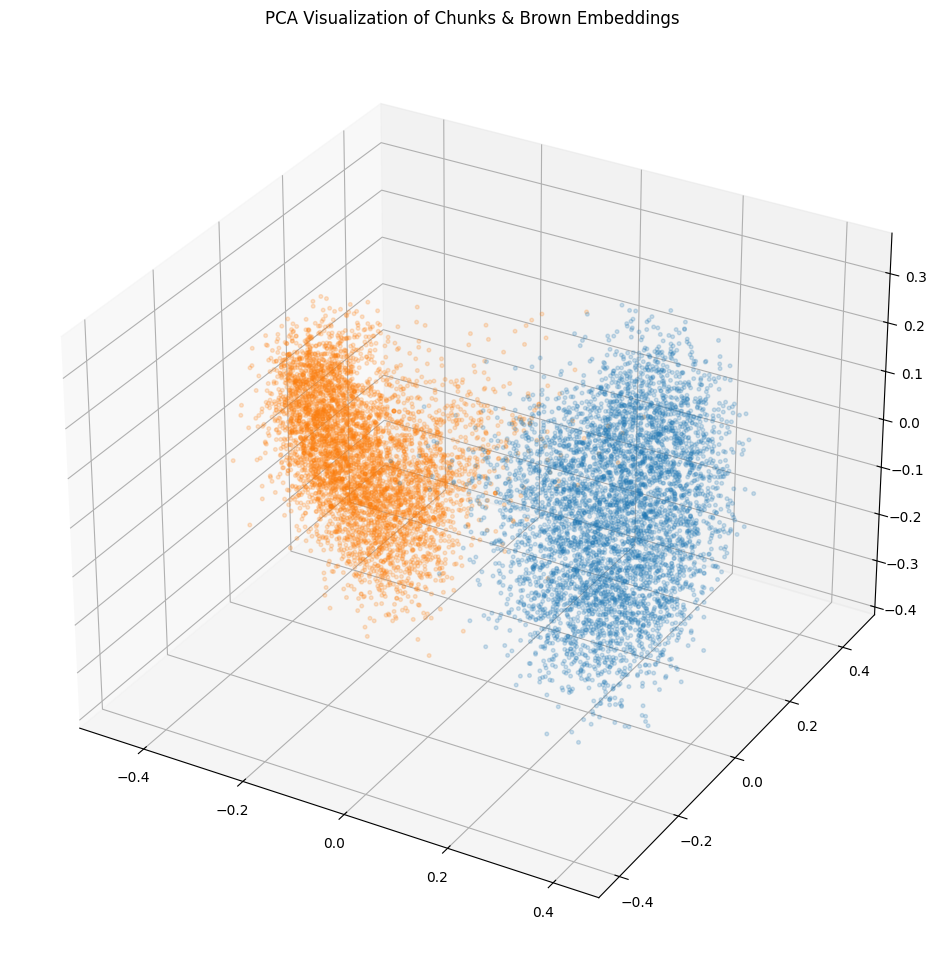

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1], all_embeddings_pca[:, 2], s=7, alpha=0.2, c=colors)
ax.set_title("PCA Visualization of Chunks & Brown Embeddings")
plt.tight_layout()
plt.legend()
plt.savefig("../plots/chunk_embeddings_pca_3d.png", dpi=300)
plt.show()

ValueError: Format 'gif' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

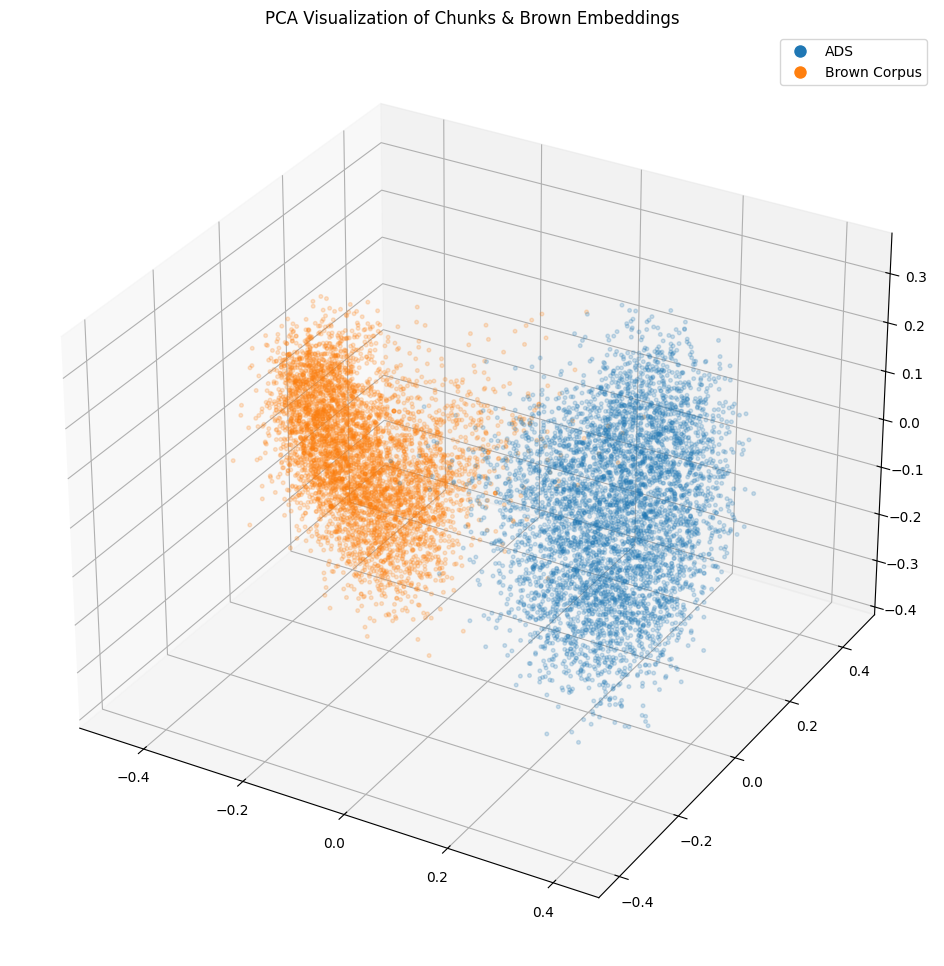

In [ ]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1], all_embeddings_pca[:, 2], s=7, alpha=0.2, c=colors)
ax.set_title("PCA Visualization of Chunks & Brown Embeddings")

# Add legend: blue = ADS, orange = Brown Corpus
legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="ADS", markerfacecolor="tab:blue", markersize=10),
    Line2D([0], [0], marker="o", color="w", label="Brown Corpus", markerfacecolor="tab:orange", markersize=10),
]
ax.legend(handles=legend_elements)


plt.savefig("../plots/rotating_pca_plot.gif", dpi=300)
plt.show()

/var/folders/br/rmys_1r571qbwgg30gx_x2l40000gn/T/ipykernel_64871/971275590.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


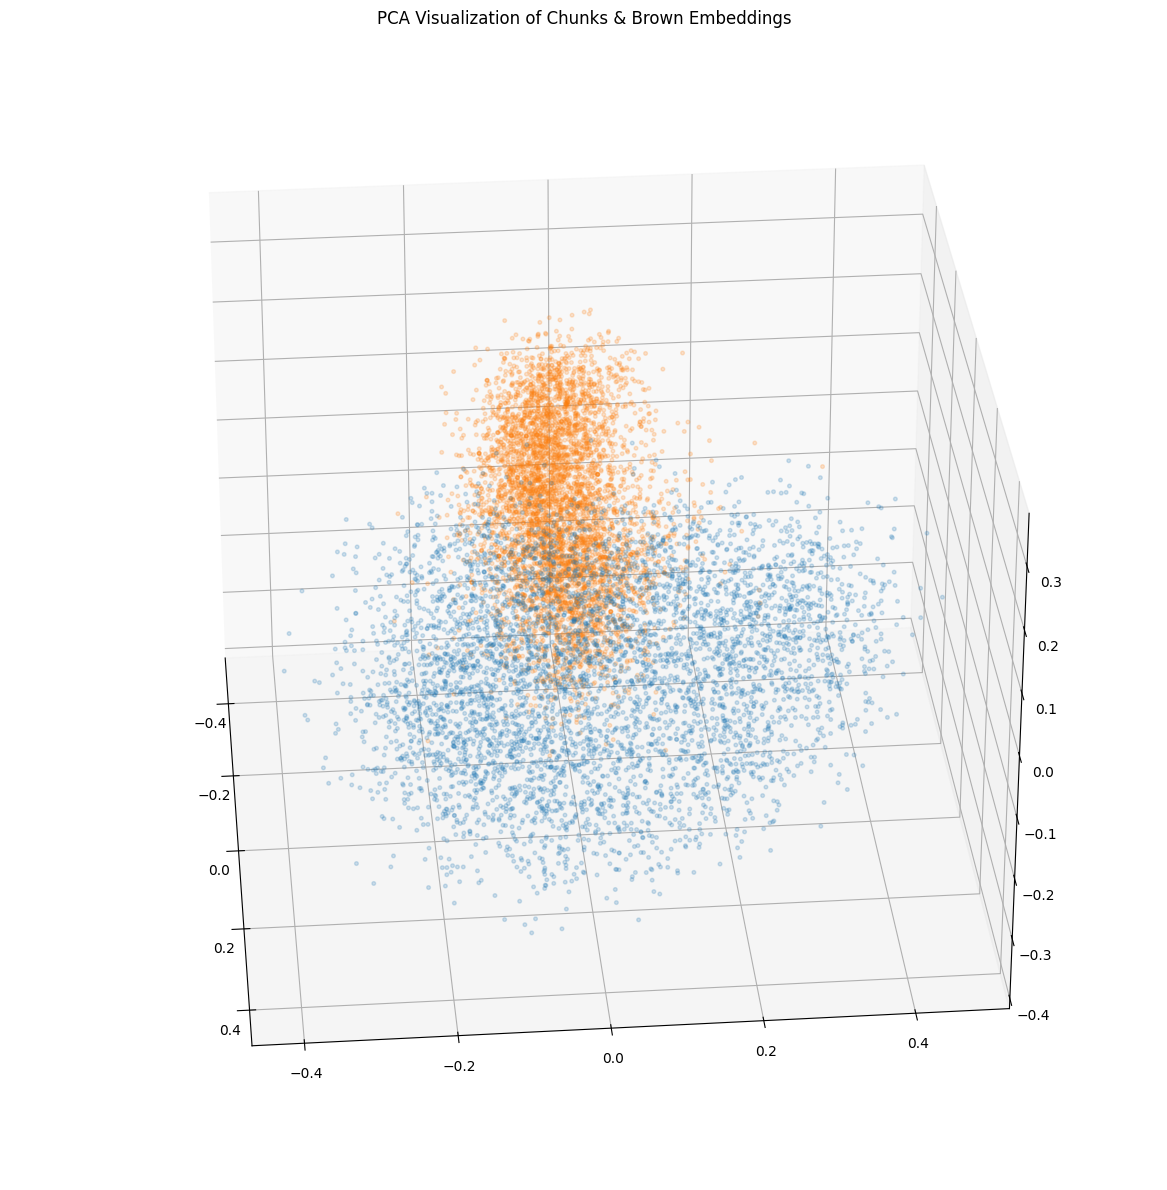

In [101]:
import imageio

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(all_embeddings_pca[:, 0], all_embeddings_pca[:, 1], all_embeddings_pca[:, 2], s=7, alpha=0.2, c=colors)
ax.set_title("PCA Visualization of Chunks & Brown Embeddings")

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="ADS", markerfacecolor="tab:blue", markersize=10),
    Line2D([0], [0], marker="o", color="w", label="Brown Corpus", markerfacecolor="tab:orange", markersize=10),
]

frames = []
for angle in range(0, 360, 5):
    ax.view_init(elev=30, azim=angle)
    # Add legend for each frame
    ax.legend(handles=legend_elements, loc="upper right")
    plt.tight_layout()
    fname = f"_tmp_rot_{angle}.png"
    plt.savefig(fname, dpi=150)
    frames.append(imageio.imread(fname))
    ax.get_legend().remove()  # Remove legend before next frame

imageio.mimsave("rotating_3d_plot.gif", frames, duration=0.05)

# Optionally, clean up temporary files
import os

for angle in range(0, 360, 5):
    os.remove(f"_tmp_rot_{angle}.png")